# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
import keras_tuner as kt
from keras.callbacks import EarlyStopping

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


# Data Preprocessing

In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode = "int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Question 2 

### a) Further split the data from year 2020 and before (i.e. those not in test set) by using data from year 2020 as validation set and the rest as the training set

In [6]:
# Split data
train_dataframe = df[df.year<2020] # TODO
val_dataframe = df[df.year==2020] # TODO
test_dataframe = df[df.year>2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

### b) For each categorical variable, replace the one-hot ecncoding with the layer  tf.keras.layers.Embedding() and set output_dim=floor(num_categories//divisor)

In [7]:
# function to get output_dim value
def output_dim(num_categories, divisor):
    return (int(np.floor(num_categories//divisor)))

In [8]:
# function to calculate the number of categories in a column
def num_categories(param):
    return (int(len(np.unique(train_dataframe[param]))))

In [9]:
# function to perform embedding
def embedding(param, divisor):
    embedded = tf.keras.layers.Embedding((num_categories(param)+1), output_dim(num_categories(param), divisor))
    return embedded

# Model Builder

In [10]:
def build_model(hp):
    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)

    # Categorcial Features encoded as Integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")

    # Categorcial Features encoded as String
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    # Numerical Features
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")

    all_inputs = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

    # Embedding implemented for all the categorical features after using 
    # lookup to get the input integer encoded -> embedded -> flattened

    # Integer Categorical Features
    month_encoded = encode_categorical_feature(month, "month", train_ds, False)
    month_embedded = embedding('month', divisor)(month_encoded)
    month_flattened = keras.layers.Flatten()(month_embedded)

    # String Categorical Features
    flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
    flat_model_type_embedded = embedding('flat_model_type', divisor)(flat_model_type_encoded)
    flat_model_type_flattened = keras.layers.Flatten()(flat_model_type_embedded)

    storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
    storey_range_embedded = embedding('storey_range', divisor)(storey_range_encoded)
    storey_range_flattened = keras.layers.Flatten()(storey_range_embedded)

    # Numerical Features
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

    all_features = layers.concatenate(
        [
            month_flattened,
            storey_range_flattened,
            flat_model_type_flattened,
            floor_area_sqm_encoded,
            remaining_lease_years_encoded,
            degree_centrality_encoded,
            eigenvector_centrality_encoded,
            dist_to_nearest_stn_encoded,
            dist_to_dhoby_encoded
        ]
    )

    units = hp.Int("units", min_value=4, max_value=32, step=4)
    
    x = layers.Dense(units=units, activation='relu')(all_features)
    output = layers.Dense(1, activation='linear')(x)
    model = keras.Model(all_inputs, output)
    
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=2e-1, sampling="log")

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.mean_squared_error, 
                  metrics=[r2, tf.keras.metrics.RootMeanSquaredError()])
    return model

### c) Via a callback, introduce early stopping (based on val_loss, with patience of 10 epochs) to the model and use KerasTuner  (with the RandomSearch algorithm) to tune the model on the validation set, according to the following ranges:

#### - Number of neurons: min=4, max=32, step=4
#### - Learning rate: min=1e-4, max=2e-1, sampling=’log’
#### - Divisor: min=1, max=2, step=1

#### Run 10 iterations of parameter search, each for 50 epochs and report best set of hyperparamters

In [11]:
# keras tuner initialisation
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective('val_loss',direction='min'),
    max_trials=10,
    overwrite = True,
    seed=SEED
)

In [12]:
# Early stopping implementation to be used in callback
es = EarlyStopping(monitor='val_loss', patience=10)

In [13]:
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[es])

Trial 10 Complete [00h 01m 26s]
val_loss: 9588917248.0

Best val_loss So Far: 2737147136.0
Total elapsed time: 00h 13m 48s
INFO:tensorflow:Oracle triggered exit


### d) Using the best model configuration train a model on the non-test split (<=2020) for 50 epochs. Plot how train and test RMSE changes across epochs

In [14]:
# Split data basedd on conditions given
train_dataframe = df[df.year<=2020] # TODO
test_dataframe = df[df.year>2020] # TODO

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

In [15]:
best_hps = tuner.get_best_hyperparameters()
best_hps[0].values

{'divisor': 1, 'units': 16, 'learning_rate': 0.1156985709194783}

In [16]:
# Saving the best hyperparamters for later use
divisor = best_hps[0].values['divisor']
units = best_hps[0].values['units']
learning_rate = best_hps[0].values['learning_rate']

In [17]:
# Building the best_model based on the best hyperparameters
model = build_model(best_hps[0])

In [18]:
checkpoint_filepath = '/tmp/checkpoint'
# Initialising callback to save the model from the best epoch
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_root_mean_squared_error',
    mode = 'min',
    save_best_only=True)

In [19]:
# Training the model with best hyperparameters along with the callback to retain the model from the best epoch
history = model.fit(train_ds, epochs=50, validation_data=test_ds, 
                    callbacks=[model_checkpoint_callback])

Epoch 1/50


/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 5s 11ms/step - loss: 37238198272.0000 - r2: -0.5443 - root_mean_squared_error: 192972.0156 - val_loss: 14102861824.0000 - val_r2: 0.4853 - val_root_mean_squared_error: 118755.4688
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: 7405379072.0000 - r2: 0.6858 - root_mean_squared_error: 86054.5156 - val_loss: 14376395776.0000 - val_r2: 0.4738 - val_root_mean_squared_error: 119901.6094
Epoch 3/50
342/342 [==============================] - 4s 9ms/step - loss: 6444868096.0000 - r2: 0.7269 - root_mean_squared_error: 80279.9375 - val_loss: 12024166400.0000 - val_r2: 0.5598 - val_root_mean_squared_error: 109654.7578
Epoch 4/50
342/342 [==============================] - 4s 9ms/step - loss: 5607975936.0000 - r2: 0.7627 - root_mean_squared_error: 74886.4219 - val_loss: 11176627200.0000 - val_r2: 0.5906 - val_root_mean_squared_error: 105719.5703
Epoch 5/50
342/342 [==============================] - 2s 5ms/step - loss: 5024336896.00

In [20]:
print(history.history.keys())

dict_keys(['loss', 'r2', 'root_mean_squared_error', 'val_loss', 'val_r2', 'val_root_mean_squared_error'])


Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

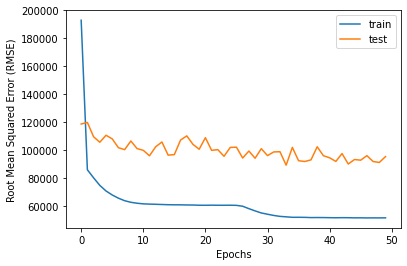

In [21]:
rmse = history.history["root_mean_squared_error"]
val_rmse = history.history["val_root_mean_squared_error"]
plt.plot(rmse[0:100])
plt.plot(val_rmse[0:100])
plt.legend(['train', 'test'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')

### e) Using the model from the best epoch, report the test R2 value and show the top 30 test samples with the largest errors.

In [22]:
val_rmse = history.history["val_root_mean_squared_error"]
val_r2 = history.history["val_r2"]

best_epoch_rmse = sys.float_info.max
best_epoch_r2 = sys.float_info.max

for i in range(len(val_rmse)):
    if val_rmse[i]<best_epoch_rmse:
        best_epoch_rmse = val_rmse[i]
        best_epoch_r2 = val_r2[i]

In [23]:
print('Test R2 value for the best epoch : ', best_epoch_r2)

Test R2 value for the best epoch :  0.7068911194801331


In [24]:
model.load_weights(checkpoint_filepath)
predict = model.predict(test_ds)

/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 1s 2ms/step


In [25]:
test_dataframe['predict'] = predict
test_dataframe = pd.DataFrame(test_dataframe)
test_dataframe['error'] = abs(test_dataframe['predict']-test_dataframe['resale_price'])/test_dataframe['resale_price']
test_dataframe = test_dataframe.sort_values(by='error', ascending=False)
test_dataframe.head(30)

<ipython-input-25-6344145ba361>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataframe['predict'] = predict


,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,predict,error
90171,2,2021,20 JALAN KLINIK,Tiong Bahru,0.289046,2.229959,0.016807,0.047782,"2 ROOM, Standard",49.000000,48.0,01 TO 03,210000.0,8.400191e+05,3.000091
94548,4,2021,534 BEDOK NORTH STREET 3,Bedok North,0.791520,9.557626,0.016807,0.000698,"2 ROOM, Improved",63.916667,45.0,01 TO 03,246944.0,9.583636e+05,2.880894
109789,10,2021,2 HOUGANG AVENUE 3,Hougang,0.917218,8.822781,0.016807,0.001507,"3 ROOM, Improved",52.833333,59.0,01 TO 03,270000.0,1.039750e+06,2.850926
91210,2,2021,85 COMMONWEALTH CLOSE,Commonwealth,0.212743,5.199732,0.016807,0.005350,"2 ROOM, Standard",45.000000,46.0,04 TO 06,218000.0,8.274156e+05,2.795485
91902,2,2021,706 YISHUN AVENUE 5,Yishun,0.688427,14.463999,0.016807,0.000382,"3 ROOM, New Generation",62.083333,68.0,07 TO 09,255000.0,9.663935e+05,2.789778
103342,7,2021,194 KIM KEAT AVENUE,Potong Pasir,1.180073,3.773605,0.016807,0.021715,"3 ROOM, Improved",51.083333,66.0,04 TO 06,256000.0,9.692913e+05,2.786294
93150,3,2021,3 JALAN BATU,Mountbatten,0.366149,4.263915,0.016807,0.016678,"3 ROOM, Standard",46.916667,60.0,04 TO 06,256000.0,9.656808e+05,2.772191
89559,1,2021,51 LORONG 6 TOA PAYOH,Braddell,0.675356,4.334529,0.016807,0.017995,"3 ROOM, Standard",61.416667,63.0,07 TO 09,262000.0,9.789821e+05,2.736573
99066,6,2021,20 JALAN KLINIK,Tiong Bahru,0.289046,2.229959,0.016807,0.047782,"2 ROOM, Standard",48.666667,48.0,01 TO 03,225000.0,8.161058e+05,2.627137
118879,4,2022,20 JALAN KLINIK,Tiong Bahru,0.289046,2.229959,0.016807,0.047782,"2 ROOM, Standard",47.833333,48.0,01 TO 03,270000.0,9.743311e+05,2.608634


#### Trends and Observations

1. Almost all have same degree centrality of 0.016807
2. Close to an MRT station with furthest one only being ~2.5 kms away
3. Far away from Dhoby Ghaut station which could mean that there is not enough data for HDBs in less populated areas as there may not be many datapoints from these places.
4. The resale prices of these HDB's were all between 200,000 - 300,000 which suggests that our model is not good at predicting the resale prices of HDB's with low resale prices. This may be because of the lack of data of HDB's with low resale prices.

## Question 3

In [26]:
# Building and fitting the best model again to get rid of the model with best epoch weights
model = build_model(best_hps[0])
# Training the model with best hyperparameters along with the callback to retain the model from the best epoch
history = model.fit(train_ds, epochs=50, validation_data=test_ds, 
                    callbacks=[model_checkpoint_callback])

Epoch 1/50


/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 3s 6ms/step - loss: 36873408512.0000 - r2: -0.5625 - root_mean_squared_error: 192024.5000 - val_loss: 13790502912.0000 - val_r2: 0.4961 - val_root_mean_squared_error: 117432.9688
Epoch 2/50
342/342 [==============================] - 3s 6ms/step - loss: 7420629504.0000 - r2: 0.6854 - root_mean_squared_error: 86143.0781 - val_loss: 13599012864.0000 - val_r2: 0.5026 - val_root_mean_squared_error: 116614.8047
Epoch 3/50
342/342 [==============================] - 3s 6ms/step - loss: 6460056576.0000 - r2: 0.7261 - root_mean_squared_error: 80374.4766 - val_loss: 12256728064.0000 - val_r2: 0.5514 - val_root_mean_squared_error: 110710.1094
Epoch 4/50
342/342 [==============================] - 3s 6ms/step - loss: 5599859200.0000 - r2: 0.7622 - root_mean_squared_error: 74832.2031 - val_loss: 11513276416.0000 - val_r2: 0.5786 - val_root_mean_squared_error: 107299.9375
Epoch 5/50
342/342 [==============================] - 3s 6ms/step - loss: 5023465472.000

### a) Apply model from Q2d on the 'old test set'. On the 'new test set', split it into 2021 and 2022/ For all 3 test sets report the test R2 value obtained

In [27]:
old_df = pd.read_csv('hdb_price_prediction_old.csv')
old_df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [28]:
# Split data
old_test_dataframe = old_df[old_df.year>2020] # TODO
new_test_2021_dataframe = df[df.year==2021]
new_test_2022_dataframe = df[df.year==2022]

old_test_ds = dataframe_to_dataset(old_test_dataframe)
new_test_2021_ds = dataframe_to_dataset(new_test_2021_dataframe)
new_test_2022_ds = dataframe_to_dataset(new_test_2022_dataframe)

old_test_ds = old_test_ds.batch(256)
new_test_2021_ds = new_test_2021_ds.batch(256)
new_test_2022_ds = new_test_2022_ds.batch(256)

#### Test R2 Value for Old Test Set

In [29]:
model.evaluate(old_test_ds)[1]

66/66 [==============================] - 0s 3ms/step - loss: 4892076032.0000 - r2: 0.8113 - root_mean_squared_error: 69943.3750


0.8112819194793701

#### Test R2 Value for New Test Set (2021)

In [30]:
model.evaluate(new_test_2021_ds)[1]

114/114 [==============================] - 1s 3ms/step - loss: 6251382272.0000 - r2: 0.7607 - root_mean_squared_error: 79065.6797


0.7606648802757263

#### Test R2 Value for New Test Set (2022)

In [31]:
model.evaluate(new_test_2022_ds)[1]

67/67 [==============================] - 0s 3ms/step - loss: 14184182784.0000 - r2: 0.4989 - root_mean_squared_error: 119097.3672


0.4988911747932434

### b) Compare the extent to which model model degradation has impacted your model to that of the team's linear regression model

The team's linear regression model degraded more than our neural network model.

When we compare the Test R2 Value for our models on the different test sets we see that our model performs better across the different test sets having ~0.5 better R2 value than that of the linear regression model.

#### Why this has occured

Linear Regression models can only predict values from sample data based on a linear equation of the weighted values from the sample.

Neural networks are capable of predicting complex data due to the nature with which they are composed of many non linear transformations. Further, having a large number of neurons makes our model more robust and resistant to change due to the nature of multiple neurons working cohesively to predict rather than just a single weighted estimation of the sample data.

This would make our model less perceptible to the change in the sample data as compared to the linear regression model

### c) With appropriate plots, visualise the distributions of all the features and labels used by the model. Which variable(s) showed the largest covariate/label shift that might have led to the drop in model performance as seen in Q3b?

In [32]:
# To help in our plotting
plot_year = lambda x:((2022,2021)[x==2021], 2020)[x<=2020]
df['plot_year'] = df['year'].apply(plot_year)

### Legend

- **2020 - Less than or equal to 2020**
- **2021 - data from 2021**
- **2022 - data from 2022**

<AxesSubplot:xlabel='month', ylabel='Count'>

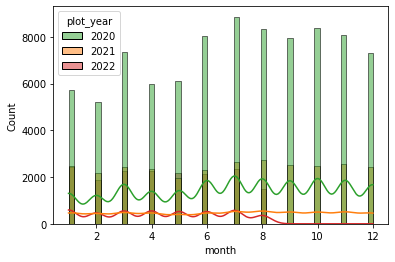

In [33]:
sns.histplot(data=df, x='month', hue='plot_year', kde=True, palette=['tab:green', 'tab:orange', 'tab:red'])

As seen in our plot for months we can see that the distribution for the year is different in the year 2021 and evidently there is no values for 2022 in October-December period since the data is not available to us

<AxesSubplot:xlabel='flat_model_type', ylabel='Count'>

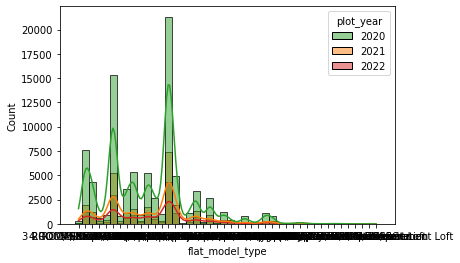

In [34]:
sns.histplot(data=df, x='flat_model_type', hue='plot_year', kde=True, palette=['tab:green', 'tab:orange', 'tab:red'])

As we can see from this plot there is no evident shift but the distribution is different for our different categories

<AxesSubplot:xlabel='dist_to_dhoby', ylabel='Count'>

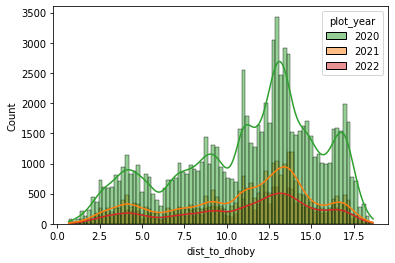

In [35]:
sns.histplot(data=df, x='dist_to_dhoby', hue='plot_year', kde=True, palette=['tab:green', 'tab:orange', 'tab:red'])

Distance to Dhoby has a slight covariate/label shift between the categories as seen from the plot

<AxesSubplot:xlabel='floor_area_sqm', ylabel='Count'>

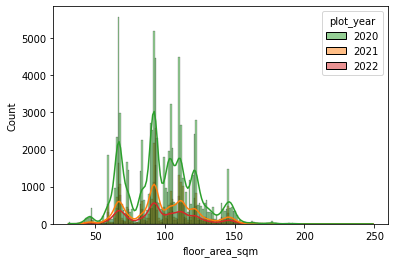

In [36]:
sns.histplot(data=df, x='floor_area_sqm', hue='plot_year', kde=True, palette=['tab:green', 'tab:orange', 'tab:red'])

Distance to Dhoby has different distributions for the different categories but no evident label/covariate shift

<AxesSubplot:xlabel='remaining_lease_years', ylabel='Count'>

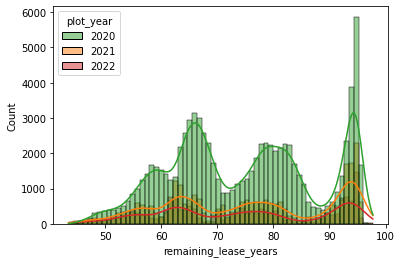

In [37]:
sns.histplot(data=df, x='remaining_lease_years', hue='plot_year', kde=True, palette=['tab:green', 'tab:orange', 'tab:red'])

Remaining Lease Years has a slight covariate/label shift between the categories as seen from the plot

<AxesSubplot:xlabel='degree_centrality', ylabel='Count'>

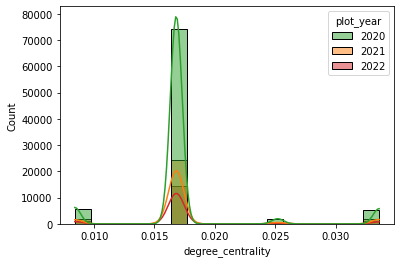

In [38]:
sns.histplot(data=df, x='degree_centrality', hue='plot_year', kde=True, palette=['tab:green', 'tab:orange', 'tab:red'])

#### Suggest a way to address the problem of model degradation.

Remove the variables/features that are likely to have a covariate/label shift between the train and the test data.

If there is a clear, visible covariate shift between our train and test data then we should remove that data since our model would not be able to predict the values correctly as there is a shift in the variance of data.

A covariate shift indicates that the range/block of values is different and has been shifted.

### d) The team passed you a script (‘RFE.py’) that recursively removes features from a neural network, so as to find the best feature subset. Run this piece of code with your model from Q2d and report the best feature subset obtained. 

In [39]:
# Split data basedd on conditions given
train_dataframe = df[df.year<=2020] # TODO
test_dataframe = df[df.year>2020] # TODO

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

In [40]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)


import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    
    # Categorcial Features encoded as Integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")

    # Categorcial Features encoded as String
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    # Numerical Features
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")

    all_inputs = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

    # Embedding implemented for all the categorical features after using 
    # lookup to get the input integer encoded -> embedded -> flattened

    # Integer Categorical Features
    month_encoded = encode_categorical_feature(month, "month", train_ds, False)
    month_embedded = embedding('month', divisor)(month_encoded)
    month_flattened = keras.layers.Flatten()(month_embedded)

    # String Categorical Features
    flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
    flat_model_type_embedded = embedding('flat_model_type', divisor)(flat_model_type_encoded)
    flat_model_type_flattened = keras.layers.Flatten()(flat_model_type_embedded)

    storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
    storey_range_embedded = embedding('storey_range', divisor)(storey_range_encoded)
    storey_range_flattened = keras.layers.Flatten()(storey_range_embedded)

    # Numerical Features
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

    all_features_input = [
            month_flattened,
            storey_range_flattened,
            flat_model_type_flattened,
            floor_area_sqm_encoded,
            remaining_lease_years_encoded,
            degree_centrality_encoded,
            eigenvector_centrality_encoded,
            dist_to_nearest_stn_encoded,
            dist_to_dhoby_encoded
        ]
    
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    
    x = layers.Dense(units=units, activation='relu')(all_features)
    output = layers.Dense(1, activation='linear')(x)
    model = keras.Model(all_inputs, output)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.mean_squared_error, 
                  metrics=[r2, tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(train_ds, epochs=50, validation_data=test_ds)    
    
    
    val_loss_hx = history.history['val_loss'] # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)


vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 12), dtype=tf.float32, name=None), name='flatten_9/Reshape:0', description="created by layer 'flatten_9'")
KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='flatten_11/Reshape:0', description="created by layer 'flatten_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 43), dtype=tf.float32, name=None), name='flatten_10/Reshape:0', description="created by layer 'flatten_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_18/truediv:0', description="created by layer 'normalization_18'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_19/truediv:0', description="created by layer 'normalization_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype

/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'plot_year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 3s 7ms/step - loss: 40502145024.0000 - r2: -0.7186 - root_mean_squared_error: 201251.4531 - val_loss: 14467784704.0000 - val_r2: 0.4707 - val_root_mean_squared_error: 120282.1016
Epoch 2/50
342/342 [==============================] - 3s 6ms/step - loss: 7633795072.0000 - r2: 0.6764 - root_mean_squared_error: 87371.5938 - val_loss: 13255220224.0000 - val_r2: 0.5157 - val_root_mean_squared_error: 115131.3203
Epoch 3/50
342/342 [==============================] - 3s 6ms/step - loss: 6796217856.0000 - r2: 0.7119 - root_mean_squared_error: 82439.1797 - val_loss: 12286391296.0000 - val_r2: 0.5506 - val_root_mean_squared_error: 110843.9922
Epoch 4/50
342/342 [==============================] - 3s 6ms/step - loss: 5996252672.0000 - r2: 0.7456 - root_mean_squared_error: 77435.4766 - val_loss: 10781586432.0000 - val_r2: 0.6053 - val_root_mean_squared_error: 103834.4219
Epoch 5/50
342/342 [==============================] - 3s 6ms/step - loss: 5343011328.000

In [41]:
all_losses

all_inputs = [
        'month',
        'storey_range',
        'flat_model_type',
        'floor_area_sqm',
        'remaining_lease_years',
        'degree_centrality',
        'eigenvector_centrality',
        'dist_to_nearest_stn',
        'dist_to_dhoby'
    ]

removed_inputs = []
for loss in all_losses:
    removed_inputs.append(all_inputs[loss.index(min(loss))])
    all_inputs.pop(loss.index(min(loss)))  
    
all_inputs = [
        'month',
        'storey_range',
        'flat_model_type',
        'floor_area_sqm',
        'remaining_lease_years',
        'degree_centrality',
        'eigenvector_centrality',
        'dist_to_nearest_stn',
        'dist_to_dhoby'
    ]

crucial_inputs = []
for losses in all_losses:
    crucial = all_inputs[losses.index(max(losses))]
    if crucial not in crucial_inputs:
        crucial_inputs.append(crucial)
    else:
        while crucial in crucial_inputs:
            losses.pop(losses.index(max(losses)))
            crucial = all_inputs[losses.index(max(losses))]

In [42]:
print('The Removed inputs are ', removed_inputs)

The Removed inputs are  ['degree_centrality', 'floor_area_sqm', 'eigenvector_centrality']


In [43]:
print('The Crucial inputs are ', crucial_inputs)

The Crucial inputs are  ['dist_to_dhoby', 'dist_to_nearest_stn', 'flat_model_type']


### e) Compare the RFE on 'old test set' to RFE on train set

Both the RFE's removed degree_centrality, but the RFE on the new test set removed floor_area_sqm, eigenvector_centrality instead of month.

Both the RFE's have dist_to_dhoby and dist_to_nearest_stn with fla_model_type as an addition on the new test set.

Concept drift has occured. When we include data from 2022 as well in the new test set the featuresw being removed are different from the features being removed in RFE on the old test set. Therefore we conclude that due to the change in the data there has been a shift/concept drift in the new data which would lead to our model predicting worse on the new test data.

# Conclusion

- In Q1, we compared a linear regression model to an equivalent neural network architecture and also saw how adding a hidden layer changes model performance.In Q2, we saw how adding an Embedding layer introduces more learnable parameters to the neural network. What other benefits do neural networks have over other machine learning approaches? In cases where neural networks perform better, is it possible to modify ‘traditional’ machine learning algorithms to close up the gap?
Machine learning is a set of algorithms that take in data as an input, learn from them and then apply what has been learned to make intelligent decisions.

Neural Networks mimic the working of a human brain through a set of algorithms.

Neural Networks can be used to perform nonlinear statistcial modelling ans provide a new alternative to logistic regression. It requires less statistical training and has the abiliity to detect complex nonlinear relationships between both dependent and independent variables.

Machine learning models can be improved by - 
1. Collecting a larger amount of training samples.
2. Feature processing and engineering - add more variables/features and create variables based on domain knowledge which would have an impact on the final prediction.
3. Parameter Tuning - consider multiple parameter values during tuning and choose the parameter which has the best accuracy/lowest loss while validating the model.

- In Q2, we tried out another approach of model tuning. KerasTuner offers many other algorithms – how do Bayesian optimisation or HyperBand work? Are they necessarily better than random search? Also, is random search better than grid search?

Bayesian Optimisation, HyperBand and Random Search are all a subset of hyperparameter tuning algorithms.

**Bayesian Optimisation** tunes hyperparameters by using a probabilistic approach. It takes into account the already tested combinations and uses this information to test the next hyperparameter combination for a test. It learns the objective function by learning based on previous data

**Hyperband** is an optimized version of RandomSearch. It takes less time to search and also takes less resources when compared to random search. Initially it only runs for 1-2 iterations to observe the performance. Then it takes the best performers and runs them for a longer number of iterations.

**Hyperband** is better than **RandomSearch** since it is more optimised but may miss out on the best hyperparameter based on the learning rates of hyperparameters. In the case of **Bayesian Optimisation** it works best when obtaining hyperparameters with less trials and long run time per iteration.

**GridSearch** is an exhaustive searching technique which will select the absolute best model from the list of hyperparameters that need to be tuned. Since RandomSearch searches through a random list it is more optimised and faster than GridSearch.